In [ ]:
!pip install git+https://github.com/Farama-Foundation/MAgent2

  Cloning https://github.com/Farama-Foundation/MAgent2 to /tmp/pip-req-build-rhzkb6j4
  Running command git clone --filter=blob:none --quiet https://github.com/Farama-Foundation/MAgent2 /tmp/pip-req-build-rhzkb6j4
  Resolved https://github.com/Farama-Foundation/MAgent2 to commit b2ddd49445368cf85d4d4e1edcddae2e28aa1406
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 847.8/847.8 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 54.5 MB/s eta 0:00:00
  Created wheel for magent2: filename=magent2-0.3.3-cp310-cp310-linux_x86_64.whl size=1696077 sha256=ea8914d429e443b8c2cb7e4c7bbd41cc485e60cd895c623ab1a67e4ca1c3be73
  Stored in directory: /tmp/pip-ephem-wheel-cache-ggupu758/wheels/e4/8e/bf/51a30bc4038546e23b81c9fb513fe6a8fd916e5a9c5f4291d5
Successfully built magent2


# QNetwork

In [ ]:
import torch
import torch.nn as nn

class QNetwork(nn.Module):
    def __init__(self, observation_shape, action_shape):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
        )
        dummy_input = torch.randn(observation_shape).permute(2, 0, 1)
        dummy_output = self.cnn(dummy_input)
        flatten_dim = dummy_output.view(-1).shape[0]
        self.network = nn.Sequential(
            nn.Linear(flatten_dim, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, action_shape),
        )

    def forward(self, x):
        assert len(x.shape) >= 3, "only support magent input observation"
        if len(x.shape) == 3:
            batchsize = 1
            x = x.unsqueeze(0)
        else:
            batchsize = x.shape[0]
        x = torch.fliplr(x).permute(0,3,1,2) # flip left-right because blue agent observe identically with red agent
        x = self.cnn(x)
        x = x.reshape(batchsize, -1)
        return self.network(x)

test = QNetwork((13,13,5), 21)
test_obs = torch.rand((13,13,5))
test(test_obs)

tensor([[ 0.0350,  0.0080,  0.0539,  0.1179,  0.0509,  0.1118, -0.0513, -0.0530,
         -0.0505, -0.1028, -0.0286, -0.0139,  0.1476, -0.0716,  0.0031, -0.0250,
          0.0514,  0.0138, -0.0496, -0.1091, -0.0391]],
       grad_fn=<AddmmBackward0>)

# Import libs

In [3]:
from collections import defaultdict, deque
import random
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import os

from magent2.environments import battle_v4

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

torch.cuda.manual_seed(42)
torch.manual_seed(42)
np.random.seed(42)

# Plot

In [1]:
def plot_metrics(episode_rewards, episode_losses, show_result=False):
    plt.figure(1)
    plt.clf()
    if show_result:
        plt.title('Result')
    else:
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Value')

    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    losses_t = torch.tensor(episode_losses, dtype=torch.float)

    plt.plot(rewards_t.numpy(), label='Reward')
    plt.plot(losses_t.numpy(), label='Loss')

    plt.legend()
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

# Replay Buffer

In [ ]:
class MultiAgentReplayBuffer:
    def __init__(self, capacity, observation_shape, action_shape):
        self.capacity = capacity
        self.observation_shape = observation_shape
        self.action_shape = action_shape

        # Use a defaultdict to automatically create deques for new agents
        self.buffers = defaultdict(lambda: {
            'obs': deque(maxlen=capacity),
            'action': deque(maxlen=capacity),
            'reward': deque(maxlen=capacity),
            'next_obs': deque(maxlen=capacity),
            'done': deque(maxlen=capacity),
        })

    def push(self, agent_id, obs, action, reward, next_obs, done):
        self.buffers[agent_id]['obs'].append(obs)
        self.buffers[agent_id]['action'].append(action)
        self.buffers[agent_id]['reward'].append(reward)
        self.buffers[agent_id]['next_obs'].append(next_obs)
        self.buffers[agent_id]['done'].append(done)

    def sample(self, batch_size):
        all_agent_ids = list(self.buffers.keys())
        if not all_agent_ids:
            return None  # No agents in the buffer

        # Check if we have enough data to sample
        total_transitions = sum(len(self.buffers[agent_id]['obs']) for agent_id in all_agent_ids)
        if total_transitions < batch_size:
            return None

        # Collect transitions from all agents into a single list
        all_transitions = []
        for agent_id in all_agent_ids:
            agent_buffer = self.buffers[agent_id]
            for i in range(len(agent_buffer['obs'])):
                all_transitions.append({
                    'obs': agent_buffer['obs'][i],
                    'action': agent_buffer['action'][i],
                    'reward': agent_buffer['reward'][i],
                    'next_obs': agent_buffer['next_obs'][i],
                    'done': agent_buffer['done'][i]
                })

        # Sample indices from the combined transitions
        indices = np.random.choice(len(all_transitions), batch_size, replace=False)

        # Extract the sampled transitions
        obs_batch = np.array([all_transitions[i]['obs'] for i in indices])
        action_batch = np.array([all_transitions[i]['action'] for i in indices])
        reward_batch = np.array([all_transitions[i]['reward'] for i in indices])
        next_obs_batch = np.array([all_transitions[i]['next_obs'] for i in indices])
        done_batch = np.array([all_transitions[i]['done'] for i in indices])

        return {
            'obs': obs_batch,
            'action': action_batch,
            'reward': reward_batch,
            'next_obs': next_obs_batch,
            'done': done_batch
        }

    def update_last_reward(self, agent_id, new_reward):
        if agent_id not in self.buffers:
            return
        self.buffers[agent_id]['reward'][-1] = new_reward

    def __len__(self):
        return sum(len(self.buffers[agent_id]['obs']) for agent_id in self.buffers)

    def clear(self, agent_id=None):
        if agent_id:
            self.buffers[agent_id]['obs'].clear()
            self.buffers[agent_id]['action'].clear()
            self.buffers[agent_id]['reward'].clear()
            self.buffers[agent_id]['next_obs'].clear()
            self.buffers[agent_id]['done'].clear()
        else:
            for agent_id in self.buffers:
                self.clear(agent_id)

# Initialize

In [5]:
env = battle_v4.env(map_size=45, minimap_mode=False, step_reward=0.01,
                        dead_penalty=-2, attack_penalty=-0.1, attack_opponent_reward=2,
                        max_cycles=300, extra_features=False, render_mode="rgb_array")

BATCH_SIZE = 128
GAMMA = 0.9
EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 50
TAU = 0.005
LR = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

observation_shape = env.observation_space("blue_0").shape
action_shape = env.action_space("blue_0").n

# Initialize networks
# policy_net = QNetwork(observation_shape, action_shape).to(device)
# red_policy_net = QNetwork(observation_shape, action_shape).to(device) # for self-play
# target_net = QNetwork(observation_shape, action_shape).to(device)
# target_net.load_state_dict(policy_net.state_dict())
# optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)


# buffer = MultiAgentReplayBuffer(10000, observation_shape, action_shape)
# steps_done = 0
# episode_rewards = []
# episode_losses = []
# running_loss = 0.0
# num_episodes = 4

cuda


## Save model

In [ ]:
def save_model(policy_net, path="models/dqn.pt"):
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
    torch.save(policy_net.state_dict(), path)

## Greedy Policy

In [ ]:
def linear_epsilon(steps_done):
    return max(EPS_END, EPS_START - (EPS_START - EPS_END) * (steps_done / EPS_DECAY))

def policy(observation, q_network):
    global steps_done
    sample = random.random()
    if sample < linear_epsilon(steps_done):
        return env.action_space("red_0").sample()
    else:
        observation = (
            torch.Tensor(observation).to(device)
        )
        with torch.no_grad():
            q_values = q_network(observation)
        return torch.argmax(q_values, dim=1).cpu().numpy()[0]

# Optimize

In [ ]:
def optimize_model():
    global running_loss

    batch = buffer.sample(BATCH_SIZE)

    # Handle cases where the buffer doesn't have enough samples yet
    if batch is None:
        return

    # Unpack the batch
    state_batch = torch.from_numpy(batch['obs']).float().to(device)
    action_batch = torch.from_numpy(batch['action']).long().to(device)
    reward_batch = torch.from_numpy(batch['reward']).float().to(device)
    next_state_batch = torch.from_numpy(batch['next_obs']).float().to(device)
    done_batch = torch.from_numpy(batch['done']).float().to(device)

    # Reshape action_batch to (BATCH_SIZE, 1) for gather()
    action_batch = action_batch.unsqueeze(1)
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    non_final_mask = (done_batch == 0).squeeze()  # Create a mask for non-terminal states

    # Only compute for non-terminal states
    if non_final_mask.any():
        next_state_values[non_final_mask] = target_net(next_state_batch[non_final_mask]).max(1).values.detach()

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    running_loss += loss.item()

    return loss.item()

# Training loop

Episode 1/4
Total Reward of previous episode: -253.31
Average Loss: 105.1241
Epsilon: 0.982
----------------------------------------


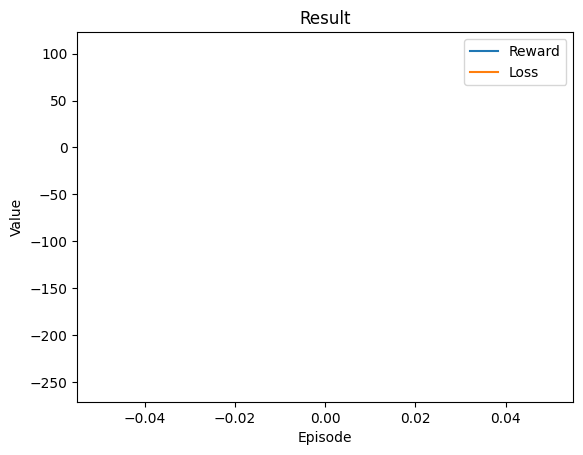

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Episode 2/4
Total Reward of previous episode: -139.75
Average Loss: 180.5789
Epsilon: 0.964
----------------------------------------


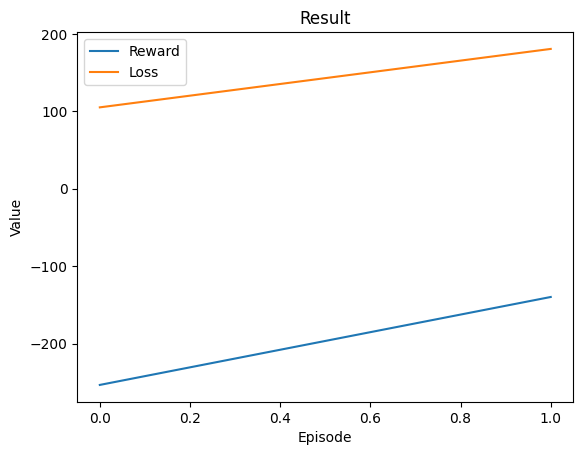

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Episode 3/4
Total Reward of previous episode: 6.66
Average Loss: 177.7584
Epsilon: 0.946
----------------------------------------


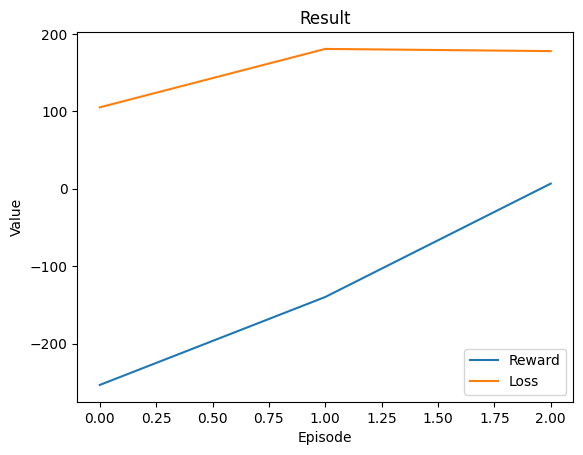

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
for i_episode in range(num_episodes):
    env.reset()
    episode_reward = 0
    running_loss = 0.0
    steps_done += 1

    for agent in env.agent_iter():

        observation, reward, termination, truncation, info = env.last()
        done = termination or truncation


        if done:
            action = None  # Agent is dead
            env.step(action)
        else:
            agent_handle = agent.split("_")
            agent_id = agent_handle[1]
            agent_team = agent_handle[0]
            if agent_team == "blue":
                episode_reward += reward

                buffer.update_last_reward(agent_id, reward) # update reward of last agent's action (bad environment!)

                action = policy(observation, policy_net)
                env.step(action)

                try:
                    next_observation = env.observe(agent)
                    agent_done = False
                except:
                    next_observation = None
                    agent_done = True

                reward = 0 # Wait for next time to be selected to get reward

                # Store the transition in buffer
                buffer.push(agent_id, observation, action, reward, next_observation, agent_done)

                # Perform one step of the optimization (on the policy network)
                optimize_model()

                # Soft update of the target network's weights
                # θ′ ← τ θ + (1 −τ )θ′
                target_net_state_dict = target_net.state_dict()
                policy_net_state_dict = policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
                target_net.load_state_dict(target_net_state_dict)

            else:
                # red agent
                action = np.random.randint(0, 21)
                env.step(action)


    # Add these lines at the end of each episode
    episode_rewards.append(episode_reward)
    episode_losses.append(running_loss)

    print(f'Episode {i_episode + 1}/{num_episodes}')
    print(f'Total Reward of previous episode: {episode_reward:.2f}')
    print(f'Average Loss: {running_loss:.4f}')
    print(f'Epsilon: {linear_epsilon(steps_done)}')
    print('-' * 40)
    save_model(policy_net, path=f"models/blue_dqn_{i_episode+1}.pt")

    plot_metrics(episode_rewards, episode_losses, show_result=True)
    plt.ioff()
    plt.show()
    save_model(policy_net, path=f"models/blue_dqn_final.pt")